# Lavaux Plot Properties

In [1]:
wd = '/home/lfloerl/microterroir/Microbiome/Metadata'
%cd $wd

/home/lfloerl/microterroir/Microbiome/Metadata


In [2]:
%env TMPDIR=/scratch/lfloerl/tmpdata

env: TMPDIR=/scratch/lfloerl/tmpdata


In [3]:
from qiime2 import Visualization
import qiime2 as q2
from qiime2 import Artifact
from qiime2 import Metadata
import os
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.patches as mpatches


from qiime2.plugins import diversity as q2d

%matplotlib inline

# VIF

In [4]:
md = pd.read_csv('ITS_lavaux.tsv', sep='\t')

In [116]:
md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Latitude', 'Longitude']]

# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']

# Using drop_first=True to avoid collinearity (dummy variable trap)
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

# Convert boolean columns to integers (0 or 1)
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)

# fill NaN
df_dummies = df_dummies.fillna(df_dummies.mean())  

# Add constant column for the VIF calculation
X = add_constant(df_dummies)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show the VIF
print(vif_data)

                Variable           VIF
0                  const  1.179437e+09
1               Altitude  3.033139e+00
2          Average_slope  1.544318e+00
3      Average_radiation  1.478196e+00
4               Latitude  1.120715e+01
5              Longitude  7.442504e+00
6  Exposition_South-West  1.209569e+00


## Correlation

<Figure size 600x600 with 0 Axes>

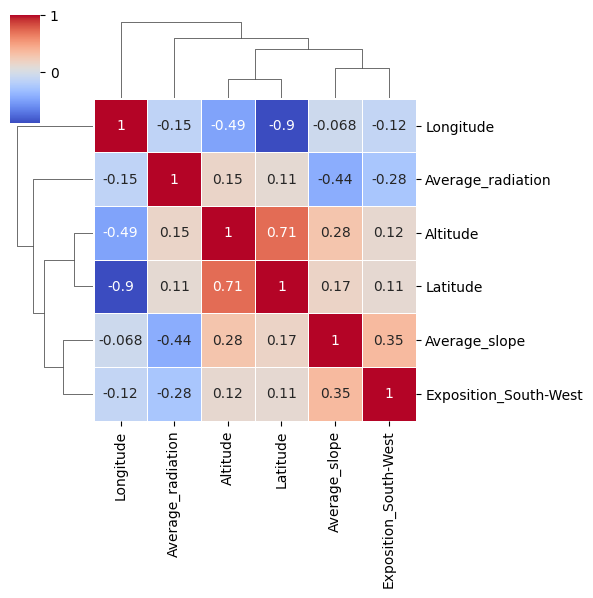

In [117]:
correlation_matrix = df_dummies.corr()

# Create a clustermap with hierarchical clustering
plt.figure(figsize=(6, 6))
sns.clustermap(correlation_matrix, cmap='coolwarm', annot=True, cbar=True, figsize=(6, 6),
               row_cluster=True, col_cluster=True, linewidths=0.5)# Customize the plot

plt.show()

## PCA

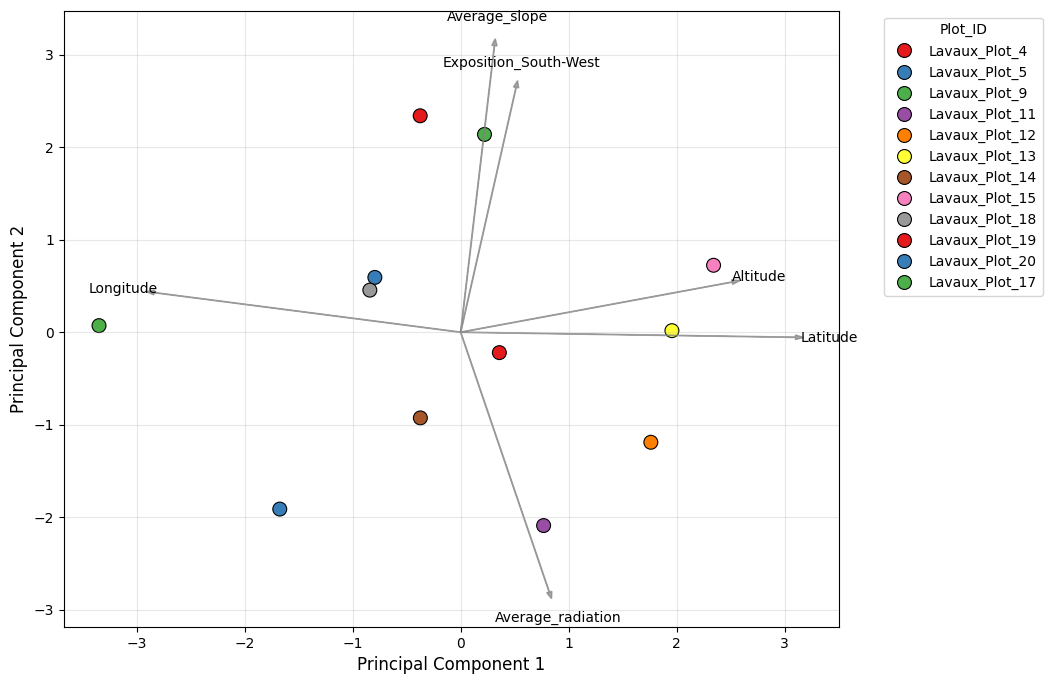

Explained Variance: PC1 = 0.40, PC2 = 0.30


In [118]:
# Prepare the data
md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Plot_ID', 'Latitude', 'Longitude']]
md_plot = md_plot.drop_duplicates()
# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']

df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

# Drop rows with missing values if needed
df_dummies = df_dummies.dropna()

# Exclude SAMPLE_NAME and Plot_ID for PCA calculations
plot_ids = df_dummies['Plot_ID']
df_dummies = df_dummies.drop(columns=['Plot_ID'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dummies)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
pca_df['Plot_ID'] = plot_ids


# Biplot: Plot PCA scores (samples)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Plot_ID', s=100, edgecolor='k', palette='Set1')

# Add arrows for each feature's contribution to PC1 and PC2
# Feature loadings for PC1 and PC2
loadings = pca.components_.T  # Transpose to get variables as rows
feature_names = df_dummies.columns

# Scale the loadings for better visualization (optional)
scaling_factor = 5  # Adjust this factor to scale the arrows
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor,
              color='gray', alpha=0.7, width=0.005, head_width=0.05)
    plt.text(loadings[i, 0] * scaling_factor * 1.1, loadings[i, 1] * scaling_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}")


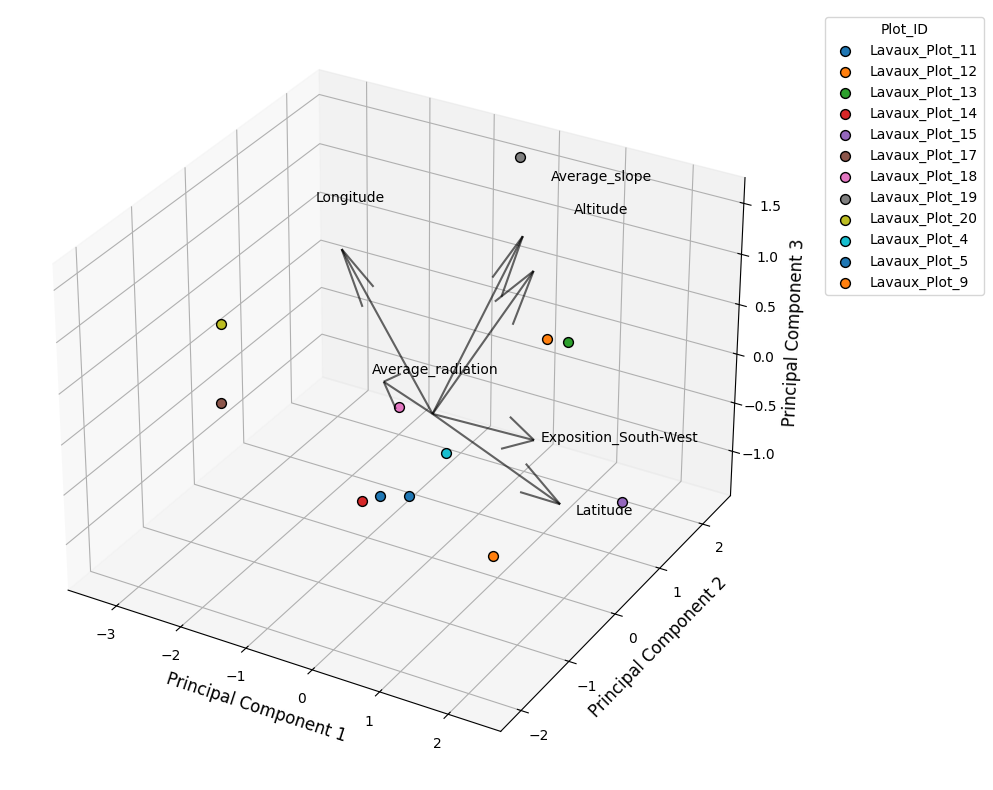

Explained Variance: PC1 = 0.40, PC2 = 0.30, PC3 = 0.12


In [119]:
# Perform PCA
pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2', 'PC3'])
pca_df['Plot_ID'] = plot_ids

# Plot the PCA results with Plot_ID as hue
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for plot_id, group in pca_df.groupby('Plot_ID'):
    ax.scatter(
        group['PC1'], group['PC2'], group['PC3'], 
        label=plot_id, 
        s=50, 
        edgecolor='k'
    )

# Add the biplot: plotting the variables as vectors
for i in range(len(df_dummies.columns)):
    ax.quiver(
        0, 0, 0,  # Origin of the vector
        pca.components_[0, i], pca.components_[1, i], pca.components_[2, i],  # Vector components
        length=2,  # Length of the vector
        normalize=True,  # Normalize vectors
        color='black',  # Vector color (red)
        alpha=0.6  # Transparency
    )
    # Add the labels for each variable associated with the vectors
    ax.text(
        pca.components_[0, i] * 3.5, 
        pca.components_[1, i] * 3.5, 
        pca.components_[2, i] * 3.5, 
        df_dummies.columns[i],  # Variable name
        color='black', 
        fontsize=10
    )

# Customize plot
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)
ax.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}, PC3 = {explained_variance[2]:.2f}")


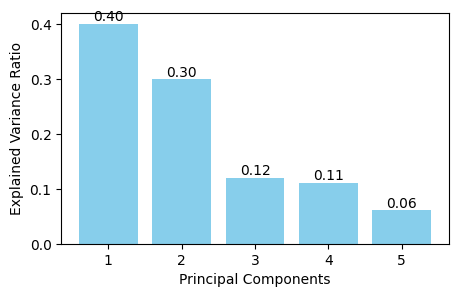

In [120]:
# Perform PCA, reduce to 5 components
pca = PCA(n_components=5)
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=[f'PC{i}' for i in range(1, 6)])
pca_df['Plot_ID'] = plot_ids

# Plot the explained variance ratios for the first 5 components (not 10)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(5,3))
bars = plt.bar(range(1, 6), explained_variance[:5], color='skyblue')
plt.xlabel('Principal Components', fontsize=10)
plt.ylabel('Explained Variance Ratio', fontsize=10)
plt.title('', fontsize=12)
plt.xticks(range(1, 6))

# Add the explained variance values on top of the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

plt.show()

# K-means clustering of the PCA

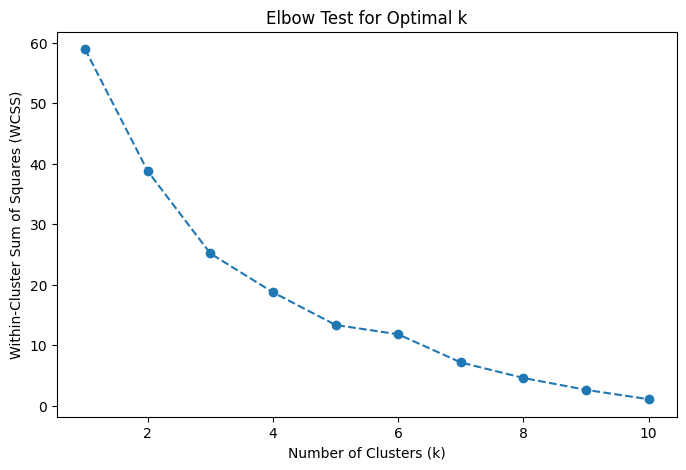

In [121]:
# PCA with 3 components already explains most of the variance 
pca = PCA(n_components=3)
pca_results = pca.fit_transform(data_scaled)

# Step 1: Perform the Elbow Test
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):  # Test for 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_results)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Test for Optimal k')
plt.show()

In [126]:
# Step 2: Perform K-Means Clustering
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_results)

# Step 3: Create DataFrame with Cluster Labels
df_clusters = pd.DataFrame({
    'Plot_ID': plot_ids,
    'Plot_PCA_kMeans_Cluster': clusters})

# save it to use as metadata 
df_clusters['Plot'] = df_clusters['Plot_ID'].str.replace('Lavaux_Plot_', '', regex=True)
df_clusters.drop(columns=['Plot_ID'], inplace=True)
df_clusters['Plot_PCA_kMeans_Cluster'] = df_clusters['Plot_PCA_kMeans_Cluster'].apply(lambda x: f'Cluster{x + 1}')
df_clusters.to_csv('/home/lfloerl/microterroir/Microbiome/Metadata/Plot_Clusters.csv', index=False)

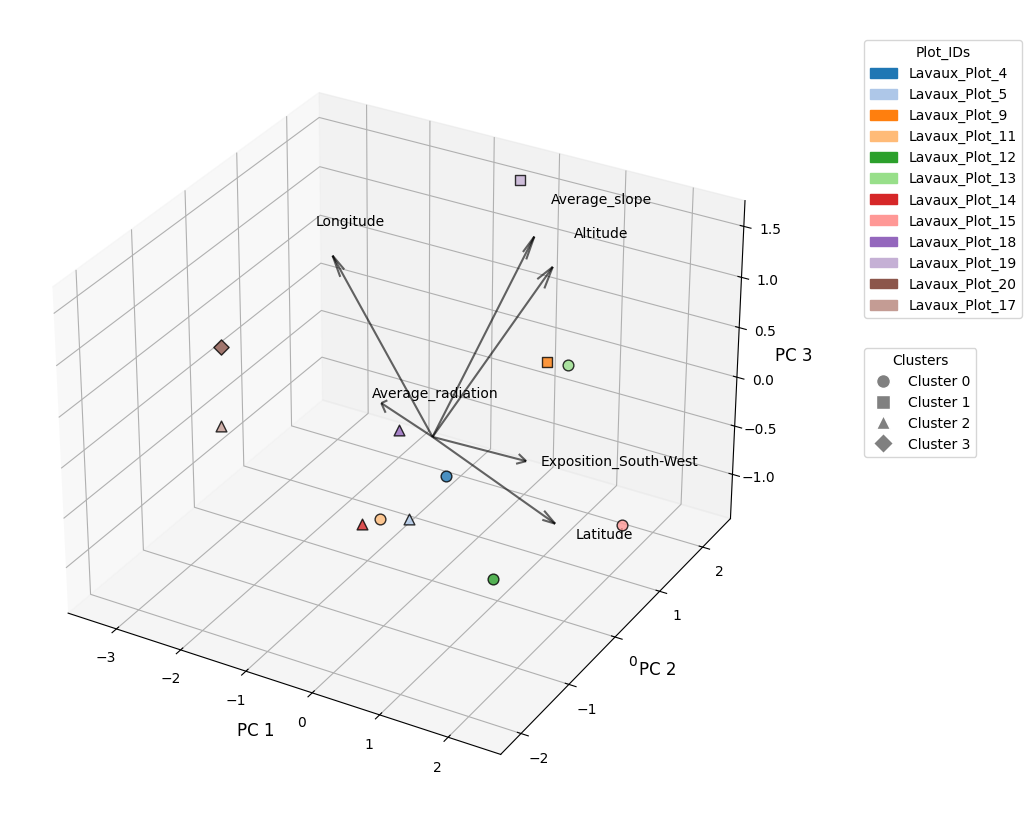

In [103]:
# Define markers for clusters
markers = ['o', 's', '^', 'D', 'X']  # Different marker shapes for up to 5 clusters

# Get unique Plot_IDs and clusters
unique_plot_ids = pca_df['Plot_ID'].unique()
unique_clusters = sorted(pca_df['Cluster'].unique())

# Create a color map for Plot_IDs
color_map = {plot_id: cm.tab20(i % 20) for i, plot_id in enumerate(unique_plot_ids)}

# Plot the 3D PCA results
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: iterate through clusters and Plot_IDs
for cluster in unique_clusters:
    for plot_id in unique_plot_ids:
        group = pca_df[(pca_df['Plot_ID'] == plot_id) & (pca_df['Cluster'] == cluster)]
        ax.scatter(
            group['PC1'], group['PC2'], group['PC3'],
            color=color_map[plot_id],  # Color by Plot_ID
            marker=markers[cluster % len(markers)],  # Shape by Cluster
            s=60,  # Marker size
            edgecolor='k',  # Black edge color
            alpha=0.8  # Transparency
        )

# Add the biplot: plotting the variables as vectors
for i in range(len(df_dummies.columns)):
    ax.quiver(
        0, 0, 0,  # Origin of the vector
        pca.components_[0, i] * 3, pca.components_[1, i] * 3, pca.components_[2, i] * 3,  # Scaled vector components
        color='black',  # Vector color
        alpha=0.6,  # Transparency
        arrow_length_ratio=0.1  # Arrowhead size
    )
    # Add labels to the vectors
    ax.text(
        pca.components_[0, i] * 3.5,
        pca.components_[1, i] * 3.5,
        pca.components_[2, i] * 3.5,
        df_dummies.columns[i],  # Variable name
        color='black', fontsize=10
    )

# Customize the plot
ax.set_xlabel('PC 1', fontsize=12)
ax.set_ylabel('PC 2', fontsize=12)
ax.set_zlabel('PC 3', fontsize=12)
ax.set_title(' ', fontsize=14)

# Add legends
# Legend for colors (Plot_IDs)
color_patches = [mpatches.Patch(color=color_map[plot_id], label=plot_id) for plot_id in unique_plot_ids]
color_legend = ax.legend(
    handles=color_patches, title='Plot_IDs', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10
)
fig.add_artist(color_legend)  # Add color legend separately

# Legend for shapes (Clusters)
shape_patches = [plt.Line2D([0], [0], marker=markers[cluster % len(markers)], color='w', 
                            markerfacecolor='gray', markersize=10, label=f'Cluster {cluster}') 
                 for cluster in unique_clusters]
shape_legend = ax.legend(
    handles=shape_patches, title='Clusters', bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize=10
)

# Adjust positions of legends to prevent overlap
color_legend.set_bbox_to_anchor((1.1, 1))  # Move the Plot_IDs legend further right
shape_legend.set_bbox_to_anchor((1.1, 0.6))  # Move the Clusters legend further right and lower


# Display the plot
plt.show()

# Make into a distance matrix 
> for 16S and ITS

In [109]:
md = pd.read_csv('ITS_lavaux.tsv', sep='\t')

md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'id', 'Latitude', 'Longitude']]

# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

df_dummies = df_dummies.dropna()

# Extract the IDs and remove the 'id' column from the DataFrame
ids = df_dummies['id']
df_dummies = df_dummies.drop(columns=['id'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dummies)

# Perform PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(data_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2', 'PC3'])
pca_df['id'] = ids.values

# Compute the pairwise Euclidean distance matrix from PCA results
distance_matrix = squareform(pdist(pca_df[['PC1', 'PC2', 'PC3']], metric='euclidean'))

# Convert the distance matrix to a DataFrame for saving
distance_df = pd.DataFrame(
    distance_matrix, 
    index=pca_df['id'], 
    columns=pca_df['id'])

# Save the distance matrix to a TSV file
distance_df.to_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/plots_distance_matrix.tsv', sep='\t')

In [110]:
md = pd.read_csv('16S_lavaux.tsv', sep='\t')

md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'id', 'Latitude', 'Longitude']]

# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

df_dummies = df_dummies.dropna()

# Extract the IDs and remove the 'id' column from the DataFrame
ids = df_dummies['id']
df_dummies = df_dummies.drop(columns=['id'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dummies)

# Perform PCA
pca = PCA(n_components=3)
pca_results = pca.fit_transform(data_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2', 'PC3'])
pca_df['id'] = ids.values

# Compute the pairwise Euclidean distance matrix from PCA results
distance_matrix = squareform(pdist(pca_df[['PC1', 'PC2', 'PC3']], metric='euclidean'))

# Convert the distance matrix to a DataFrame for saving
distance_df = pd.DataFrame(
    distance_matrix, 
    index=pca_df['id'], 
    columns=pca_df['id'])

# Save the distance matrix to a TSV file
distance_df.to_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/16S/lavaux/spatio-temporal/plots_distance_matrix.tsv', sep='\t')

<hr>

# Try again withouth the spatial element

# VIF

In [127]:
md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation']]

# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']

# Using drop_first=True to avoid collinearity (dummy variable trap)
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

# Convert boolean columns to integers (0 or 1)
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)

# fill NaN
df_dummies = df_dummies.fillna(df_dummies.mean())  

# Add constant column for the VIF calculation
X = add_constant(df_dummies)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Show the VIF
print(vif_data)

                Variable          VIF
0                  const  4795.990421
1               Altitude     1.217358
2          Average_slope     1.535910
3      Average_radiation     1.417177
4  Exposition_South-West     1.171729


## Correlation

<Figure size 600x600 with 0 Axes>

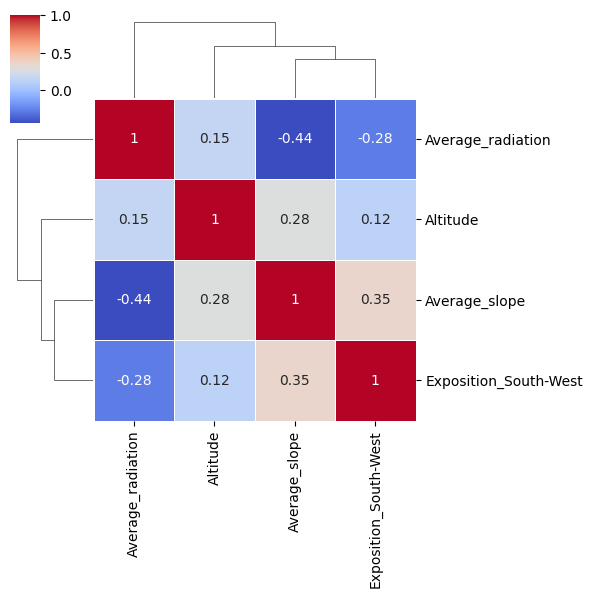

In [128]:
correlation_matrix = df_dummies.corr()

# Create a clustermap with hierarchical clustering
plt.figure(figsize=(6, 6))
sns.clustermap(correlation_matrix, cmap='coolwarm', annot=True, cbar=True, figsize=(6, 6),
               row_cluster=True, col_cluster=True, linewidths=0.5)# Customize the plot

plt.show()

## PCA

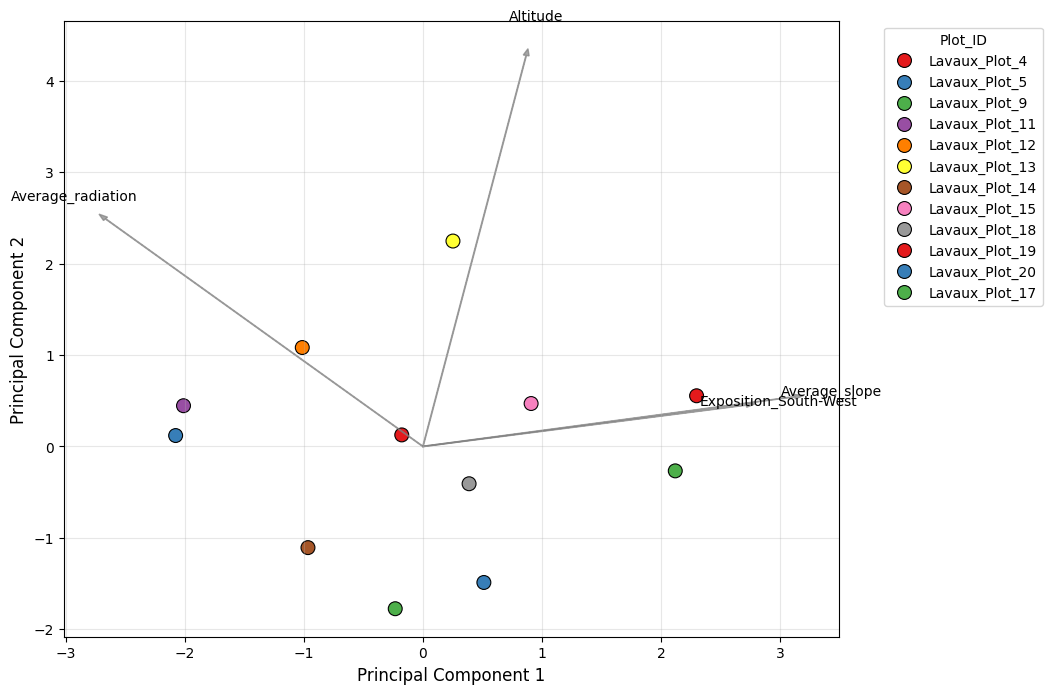

Explained Variance: PC1 = 0.45, PC2 = 0.29


In [129]:
# Prepare the data
md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Plot_ID']]
md_plot = md_plot.drop_duplicates()
# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']

df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

# Drop rows with missing values if needed
df_dummies = df_dummies.dropna()

# Exclude SAMPLE_NAME and Plot_ID for PCA calculations
plot_ids = df_dummies['Plot_ID']
df_dummies = df_dummies.drop(columns=['Plot_ID'])

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dummies)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
pca_df['Plot_ID'] = plot_ids


# Biplot: Plot PCA scores (samples)
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Plot_ID', s=100, edgecolor='k', palette='Set1')

# Add arrows for each feature's contribution to PC1 and PC2
# Feature loadings for PC1 and PC2
loadings = pca.components_.T  # Transpose to get variables as rows
feature_names = df_dummies.columns

# Scale the loadings for better visualization (optional)
scaling_factor = 5  # Adjust this factor to scale the arrows
for i, feature in enumerate(feature_names):
    plt.arrow(0, 0, loadings[i, 0] * scaling_factor, loadings[i, 1] * scaling_factor,
              color='gray', alpha=0.7, width=0.005, head_width=0.05)
    plt.text(loadings[i, 0] * scaling_factor * 1.1, loadings[i, 1] * scaling_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}")


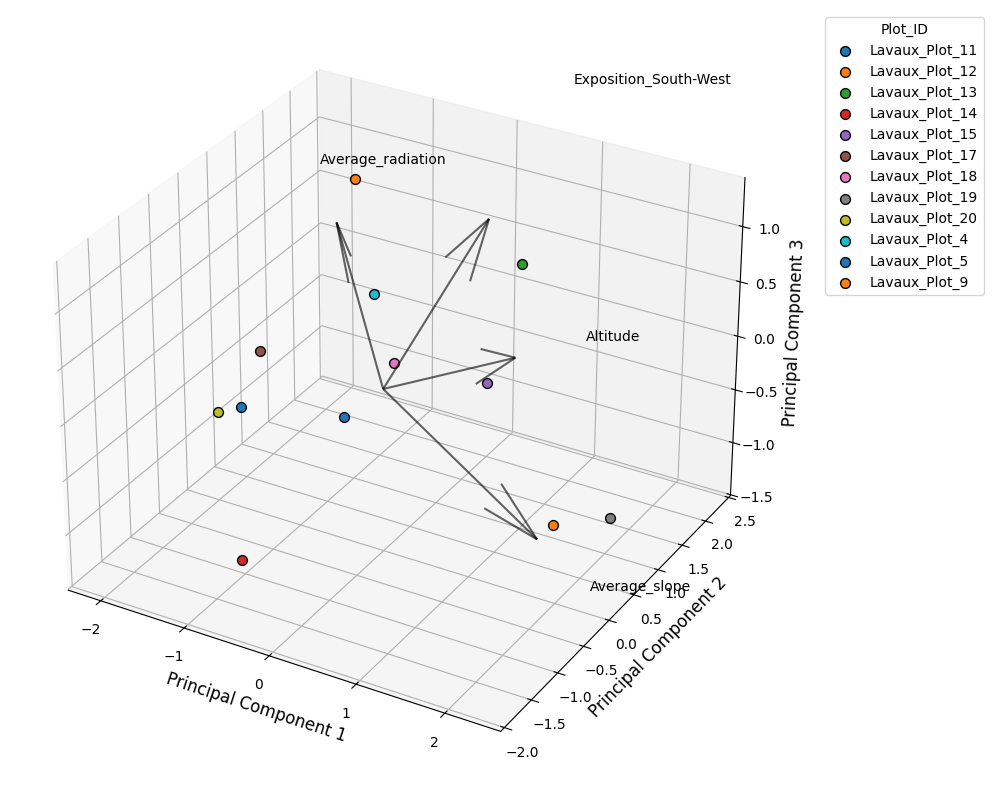

Explained Variance: PC1 = 0.45, PC2 = 0.29, PC3 = 0.17


In [130]:
# Perform PCA
pca = PCA(n_components=3)  # Reduce to 3 dimensions
pca_results = pca.fit_transform(data_scaled)

# Create a dataframe with the PCA results
pca_df = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2', 'PC3'])
pca_df['Plot_ID'] = plot_ids

# Plot the PCA results with Plot_ID as hue
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
for plot_id, group in pca_df.groupby('Plot_ID'):
    ax.scatter(
        group['PC1'], group['PC2'], group['PC3'], 
        label=plot_id, 
        s=50, 
        edgecolor='k'
    )

# Add the biplot: plotting the variables as vectors
for i in range(len(df_dummies.columns)):
    ax.quiver(
        0, 0, 0,  # Origin of the vector
        pca.components_[0, i], pca.components_[1, i], pca.components_[2, i],  # Vector components
        length=2,  # Length of the vector
        normalize=True,  # Normalize vectors
        color='black',  # Vector color (red)
        alpha=0.6  # Transparency
    )
    # Add the labels for each variable associated with the vectors
    ax.text(
        pca.components_[0, i] * 3.5, 
        pca.components_[1, i] * 3.5, 
        pca.components_[2, i] * 3.5, 
        df_dummies.columns[i],  # Variable name
        color='black', 
        fontsize=10
    )

# Customize plot
ax.set_xlabel('Principal Component 1', fontsize=12)
ax.set_ylabel('Principal Component 2', fontsize=12)
ax.set_zlabel('Principal Component 3', fontsize=12)
ax.legend(title='Plot_ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

# Optional: Print explained variance ratios
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]:.2f}, PC2 = {explained_variance[1]:.2f}, PC3 = {explained_variance[2]:.2f}")


# K-means clustering of the PCA

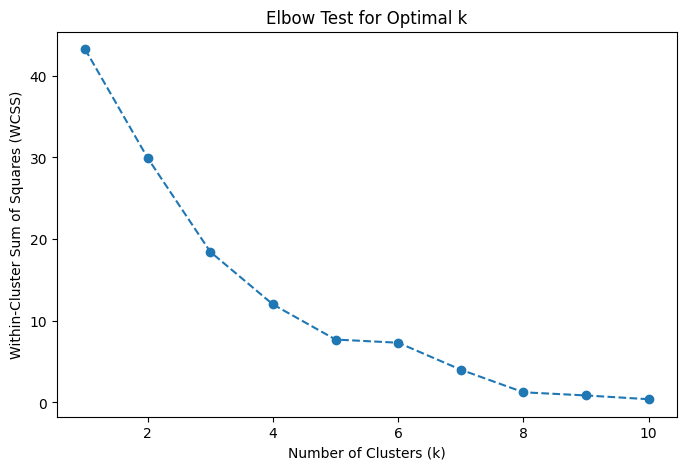

In [135]:
# PCA with 3 components already explains most of the variance 
pca = PCA(n_components=3)
pca_results = pca.fit_transform(data_scaled)

# Step 1: Perform the Elbow Test
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):  # Test for 1 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_results)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Test for Optimal k')
plt.show()

In [138]:
# Step 2: Perform K-Means Clustering
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(pca_results)

# Step 3: Create DataFrame with Cluster Labels
df_clusters = pd.DataFrame({
    'Plot_ID': plot_ids,
    'Plot_PCA_kMeans_Cluster': clusters})

# save it to use as metadata 
df_clusters['Plot'] = df_clusters['Plot_ID'].str.replace('Lavaux_Plot_', '', regex=True)
df_clusters.drop(columns=['Plot_ID'], inplace=True)
df_clusters['Plot_PCA_kMeans_Cluster'] = df_clusters['Plot_PCA_kMeans_Cluster'].apply(lambda x: f'Cluster{x + 1}')
#df_clusters.to_csv('/home/lfloerl/microterroir/Microbiome/Metadata/Plot_Clusters.csv', index=False)

df_clusters

,Plot_PCA_kMeans_Cluster,Plot
0,Cluster1,4
1,Cluster3,5
2,Cluster2,9
3,Cluster4,11
4,Cluster1,12
5,Cluster2,13
6,Cluster4,14
7,Cluster2,15
8,Cluster3,18
9,Cluster2,19


<hr>

# For Partial Mantel: Make distance matrice of properties and location

* Euclidian distance of properties 

* for 16S and ITS seperately

## Properties

In [8]:
# Load data
md = pd.read_csv('ITS_lavaux.tsv', sep='\t')

# Select relevant columns
md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'id']]

# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

# Drop rows with missing values
df_dummies = df_dummies.dropna()

# Convert boolean columns to integers (0 or 1)
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)

# Extract IDs before dropping the 'id' column
ids = df_dummies['id']
df_dummies = df_dummies.drop(columns=['id'])

# Compute the pairwise Euclidean distance matrix
distance_matrix = squareform(pdist(df_dummies, metric='euclidean'))

# Convert the distance matrix to a DataFrame
distance_df = pd.DataFrame(distance_matrix, index=ids, columns=ids)

# Save the distance matrix to a TSV file
distance_df.to_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/plot_properties_euclidian_distance_matrix.tsv', sep='\t')

In [10]:
distance_df

id,364528_290-LP3-16S-0866,364528_289-LP3-16S-0865,364528_285-LP3-16S-0861,364528_287-LP3-16S-0863,364528_282-LP3-16S-0858,364528_286-LP3-16S-0862,364528_278-LP3-16S-0854,364528_280-LP3-16S-0856,364528_277-LP3-16S-0853,364528_276-LP3-16S-0852,...,364528_510-LP3-16S-1086,364528_511-LP3-16S-1087,364528_501-LP3-16S-1077,364528_502-LP3-16S-1078,364528_504-LP3-16S-1080,364528_497-LP3-16S-1073,364528_500-LP3-16S-1076,364528_505-LP3-16S-1081,364528_507-LP3-16S-1083,364527_273-LP3-16S-0273
id,,,,,,,,,,,,,,,,,,,,,
364528_290-LP3-16S-0866,0.000000,55.901699,86.168440,41.243181,71.589105,130.000000,27.404379,74.330344,32.403703,68.007353,...,68.007353,55.901699,68.007353,0.000000,55.901699,41.243181,130.000000,86.168440,0.000000,55.901699
364528_289-LP3-16S-0865,55.901699,0.000000,122.678441,93.946793,123.490890,181.727818,40.323690,120.000000,70.178344,111.803399,...,111.803399,0.000000,111.803399,55.901699,0.000000,93.946793,181.727818,122.678441,55.901699,0.000000
364528_285-LP3-16S-0861,86.168440,122.678441,0.000000,60.216277,53.851648,78.262379,84.415638,25.495098,56.789083,30.822070,...,30.822070,122.678441,30.822070,86.168440,122.678441,60.216277,78.262379,0.000000,86.168440,122.678441
364528_287-LP3-16S-0863,41.243181,93.946793,60.216277,0.000000,30.430248,90.559373,56.124861,40.323690,32.419130,43.886217,...,43.886217,93.946793,43.886217,41.243181,93.946793,0.000000,90.559373,60.216277,41.243181,93.946793
364528_282-LP3-16S-0858,71.589105,123.490890,53.851648,30.430248,0.000000,61.846584,84.415638,29.154759,56.789083,44.158804,...,44.158804,123.490890,44.158804,71.589105,123.490890,30.430248,61.846584,53.851648,71.589105,123.490890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364528_497-LP3-16S-1073,41.243181,93.946793,60.216277,0.000000,30.430248,90.559373,56.124861,40.323690,32.419130,43.886217,...,43.886217,93.946793,43.886217,41.243181,93.946793,0.000000,90.559373,60.216277,41.243181,93.946793
364528_500-LP3-16S-1076,130.000000,181.727818,78.262379,90.559373,61.846584,0.000000,142.306008,65.000000,112.915898,76.974022,...,76.974022,181.727818,76.974022,130.000000,181.727818,90.559373,0.000000,78.262379,130.000000,181.727818
364528_505-LP3-16S-1081,86.168440,122.678441,0.000000,60.216277,53.851648,78.262379,84.415638,25.495098,56.789083,30.822070,...,30.822070,122.678441,30.822070,86.168440,122.678441,60.216277,78.262379,0.000000,86.168440,122.678441


In [9]:
# Load data
md = pd.read_csv('16S_lavaux.tsv', sep='\t')

# Select relevant columns
md_plot = md[['Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'id']]

# Convert categorical columns to dummy variables
categorical_cols = ['Exposition']
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)

# Drop rows with missing values
df_dummies = df_dummies.dropna()

# Convert boolean columns to integers (0 or 1)
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)

# Extract IDs before dropping the 'id' column
ids = df_dummies['id']
df_dummies = df_dummies.drop(columns=['id'])

# Compute the pairwise Euclidean distance matrix
distance_matrix = squareform(pdist(df_dummies, metric='euclidean'))

# Convert the distance matrix to a DataFrame
distance_df = pd.DataFrame(distance_matrix, index=ids, columns=ids)

# Save the distance matrix to a TSV file
distance_df.to_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/16S/lavaux/spatio-temporal/plot_properties_euclidian_distance_matrix.tsv', sep='\t')

# Investigate Plot 14 and Plot 17 which have significant intra-vineyard berry fungal microbiome distance decay

In [11]:
md = pd.read_csv('ITS_lavaux.tsv', sep='\t')

md_plot = md[['Plot_ID','Altitude', 'Average_slope', 'Exposition', 'Average_radiation', 'Latitude', 'Longitude']]

categorical_cols = ['Exposition']
# Using drop_first=True to avoid collinearity (dummy variable trap)
df_dummies = pd.get_dummies(md_plot, columns=categorical_cols, drop_first=True)
# Convert boolean columns to integers (0 or 1)
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)
df_dummies

,Plot_ID,Altitude,Average_slope,Average_radiation,Latitude,Longitude,Exposition_South-West
0,Lavaux_Plot_4,450,30,937.5,46.498857,6.708072,1
1,Lavaux_Plot_5,400,30,912.5,46.496407,6.708712,1
2,Lavaux_Plot_9,520,35,887.5,46.499468,6.712242,1
3,Lavaux_Plot_11,490,20,937.5,46.500244,6.706655,0
4,Lavaux_Plot_12,520,15,937.5,46.502628,6.704952,1
...,...,...,...,...,...,...,...
590,Lavaux_Plot_11,490,20,937.5,46.500244,6.706655,0
591,Lavaux_Plot_13,580,30,937.5,46.499992,6.706109,1
592,Lavaux_Plot_9,520,35,887.5,46.499468,6.712242,1
593,Lavaux_Plot_4,450,30,937.5,46.498857,6.708072,1


In [13]:
# Filter out Plot 14 and Plot 17
selected_plots = df_dummies[df_dummies['Plot_ID'].isin(['Lavaux_Plot_14', 'Lavaux_Plot_17'])]
other_plots = df_dummies[~df_dummies['Plot_ID'].isin(['Lavaux_Plot_14', 'Lavaux_Plot_17'])]

# Compute mean and standard deviation for other plots
stats = other_plots[['Altitude', 'Average_slope', 'Exposition_South-West', 
                     'Average_radiation', 'Latitude', 'Longitude']].agg(['mean', 'std'])

# Compare selected plots to stats
comparison = selected_plots.set_index('Plot_ID')[['Altitude', 'Average_slope', 'Exposition_South-West', 
                                                  'Average_radiation', 'Latitude', 'Longitude']]

z_scores = (comparison - stats.loc['mean']) / stats.loc['std']

# Display plots with significant deviations (e.g., |z-score| > 1.5)
outliers = z_scores.abs() > 1.5
z_scores[outliers]

,Altitude,Average_slope,Exposition_South-West,Average_radiation,Latitude,Longitude
Plot_ID,,,,,,
Lavaux_Plot_14,NaN,NaN,-2.06139,NaN,NaN,NaN
Lavaux_Plot_17,-2.187815,NaN,NaN,NaN,-2.973425,2.12944
Lavaux_Plot_14,NaN,NaN,-2.06139,NaN,NaN,NaN
Lavaux_Plot_17,-2.187815,NaN,NaN,NaN,-2.973425,2.12944
Lavaux_Plot_14,NaN,NaN,-2.06139,NaN,NaN,NaN
...,...,...,...,...,...,...
Lavaux_Plot_17,-2.187815,NaN,NaN,NaN,-2.973425,2.12944
Lavaux_Plot_17,-2.187815,NaN,NaN,NaN,-2.973425,2.12944
Lavaux_Plot_14,NaN,NaN,-2.06139,NaN,NaN,NaN


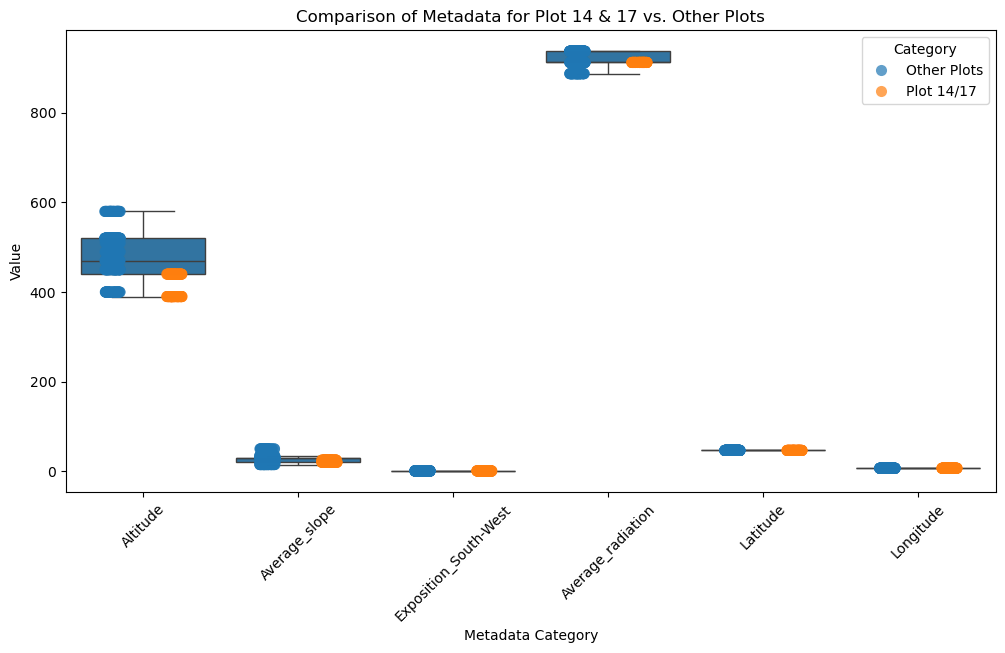

In [14]:
# Melt the dataframe for easier plotting
md_melted = df_dummies.melt(id_vars=['Plot_ID'], value_vars=['Altitude', 'Average_slope', 'Exposition_South-West', 
                                                      'Average_radiation', 'Latitude', 'Longitude'], 
                     var_name='Metadata', value_name='Value')

# Mark Plot 14 and Plot 17 separately
md_melted['Highlight'] = md_melted['Plot_ID'].apply(lambda x: 'Plot 14/17' if x in ['Lavaux_Plot_14', 'Lavaux_Plot_17'] else 'Other Plots')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Metadata', y='Value', data=md_melted, showfliers=False)
sns.stripplot(x='Metadata', y='Value', data=md_melted, hue='Highlight', dodge=True, marker='o', size=8, alpha=0.7)

plt.xticks(rotation=45)
plt.xlabel('Metadata Category')
plt.ylabel('Value')
plt.title('Comparison of Metadata for Plot 14 & 17 vs. Other Plots')
plt.legend(title='Category', loc='upper right')
plt.show()

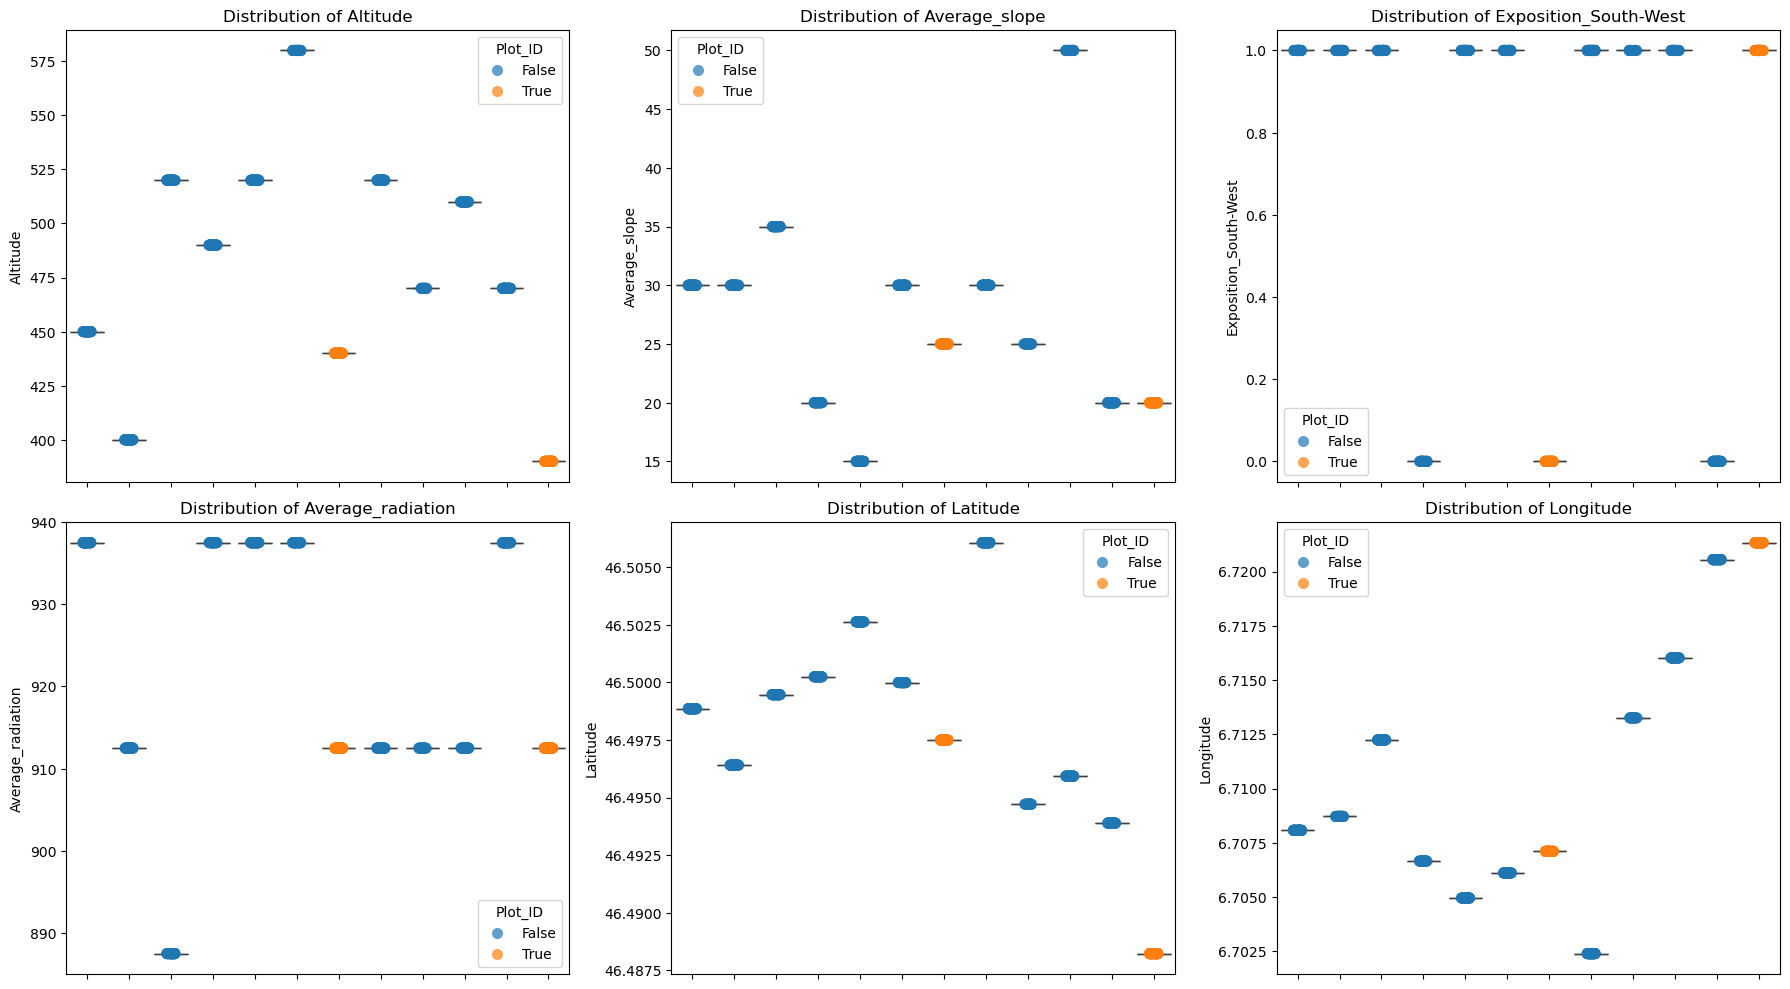

In [16]:
metadata_cols = ['Altitude', 'Average_slope', 'Exposition_South-West', 'Average_radiation', 'Latitude', 'Longitude']

# Set up the figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each metadata category and create a boxplot
for i, col in enumerate(metadata_cols):
    sns.boxplot(data=df_dummies, x='Plot_ID', y=col, ax=axes[i], showfliers=False)
    sns.stripplot(data=df_dummies, x='Plot_ID', y=col, hue=df_dummies['Plot_ID'].isin(['Lavaux_Plot_14', 'Lavaux_Plot_17']),
                  dodge=False, marker='o', size=8, alpha=0.7, ax=axes[i])
    
    axes[i].set_xticklabels([])
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()
